In [1]:
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, kpss
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA 
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
import pandas_datareader as pdr
import ta

import warnings
warnings.filterwarnings("ignore")

import estimation

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

mt5.initialize()


True

# Импорт списка доступных инструментов          
Выбираю активы с низким спредом

In [2]:
def extract_symbols_info():
    """Извлечение информации о символах и создание df"""
    symbols = []
    sectors = []
    descriptions = []
    symbols_info = mt5.symbols_get()
    symbols_info_list = list(symbols_info)
    
    for element in symbols_info_list:
        symbols.append(list(element)[-3])
        sectors.append(list(element)[-1].split("\\")[0])
        descriptions.append(list(element)[-7])
    
    info_df = pd.DataFrame({
        "Symbol": symbols,
        "Sector": sectors,
        "Description": descriptions
    })
    
    print(f"Извлечено {len(symbols)} символов")
    return info_df

def calculate_spread(info_df):
    """Расчет спреда для каждого символа"""
    spreads = []
    
    for symbol in info_df["Symbol"]:
        try:
            tick_info = mt5.symbol_info_tick(symbol)
            if tick_info is not None:
                ask = tick_info.ask
                bid = tick_info.bid
                spread = (ask - bid) / bid
                spreads.append(spread)
            else:
                spreads.append(None)
                print(f"Нет спреда по символу: {symbol}")
        except Exception as e:
            print(f"Ошибка получения информации по символу {symbol}: {e}")
            spreads.append(None)
    
    info_df["Spread"] = spreads
    return info_df

def filter_low_spread(info_df, threshold=0.0007):
    """Фильтрация активов со спредом ниже указанного порога"""
    low_spread_assets = info_df.dropna().loc[info_df["Spread"] < threshold]
    low_spread_assets = low_spread_assets.sort_values(by="Spread")
    print(f"Найдено {len(low_spread_assets)} активов с низким спредом ниже {threshold}")
    return low_spread_assets

# Основной блок выполнения кода
informations = extract_symbols_info()
informations_with_spread = calculate_spread(informations)
low_spread = filter_low_spread(informations_with_spread)

Извлечено 94 символов
Найдено 71 активов с низким спредом ниже 0.0007


# Функция загрузки данных

In [3]:
def get_rates(symbol, n, timeframe=mt5.TIMEFRAME_D1):
    """Функция, которая возвращает данные по символу"""
    
    # Инициализация устройства MetaTrader
    mt5.initialize()
    
    # Получение данных в df
    utc_from = datetime.now() + timedelta(hours=3)  # Текущее время терминала
    data = mt5.copy_rates_from(symbol, timeframe, utc_from, n)  
    rates_frame = pd.DataFrame(data)  
    
    # Преобразование времени из секунд в формат datetime
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')  
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], format='%Y-%m-%d')  
    rates_frame['month'] = rates_frame['time'].dt.month  
    rates_frame['year'] = rates_frame['time'].dt.year  
    rates_frame = rates_frame.set_index('time')  
    rates_frame.dropna(inplace=True)  

    # Вычисление первой цены открытия каждого месяца и года
    rates_frame['first_open_month'] = rates_frame.groupby(['year', 'month'])['open'].transform('first')
    rates_frame['first_open_year'] = rates_frame.groupby(['year'])['open'].transform('first')
    # Вычисление сезонных отклонений
    rates_frame['seasons_month'] = ((rates_frame ["open"] - rates_frame["first_open_year"]) / rates_frame["first_open_year"] * 100)
    rates_frame['seasons_year'] = ((rates_frame ["open"] - rates_frame["first_open_month"]) / rates_frame["first_open_month"] * 100)

    # Вставка символа в df
    rates_frame.insert(0, 'symbol', symbol)
 
    # Удаление ненужных столбцов
    rates_frame.drop(['spread', 'real_volume', 'month', 'first_open_month', 'first_open_year'], axis=1, inplace=True)

    # Подсчет количества записей для каждого года
    year_counts = rates_frame['year'].value_counts()
    # Отбор годов, в которых количество записей меньше 250 или больше 270, за исключением текущего года
    years_to_remove = year_counts[((year_counts < 250) | (year_counts > 270)) & (year_counts.index != datetime.now().year)].index
    # Удаление строк с этими годами из df
    rates_frame = rates_frame[~rates_frame['year'].isin(years_to_remove)]

    return rates_frame


Для теста загружу данные по EURUSD

In [4]:
eur = get_rates('EURUSD', 4000)

In [5]:
eur

,symbol,open,high,low,close,tick_volume,year,seasons_month,seasons_year
time,,,,,,,,,
2013-01-02,EURUSD,1.32660,1.32930,1.31560,1.31860,87728,2013,0.00000,0.00000
2013-01-03,EURUSD,1.31860,1.31900,1.30470,1.30490,101869,2013,-0.60305,-0.60305
2013-01-04,EURUSD,1.30480,1.30890,1.29970,1.30650,103903,2013,-1.64330,-1.64330
2013-01-07,EURUSD,1.30750,1.31190,1.30170,1.31160,101842,2013,-1.43977,-1.43977
2013-01-08,EURUSD,1.31160,1.31400,1.30560,1.30810,103145,2013,-1.13071,-1.13071
...,...,...,...,...,...,...,...,...,...
2024-08-21,EURUSD,1.11279,1.11735,1.10976,1.11506,73796,2024,1.00296,2.79815
2024-08-22,EURUSD,1.11496,1.11642,1.10976,1.11107,70520,2024,1.19992,2.99861
2024-08-23,EURUSD,1.11097,1.12003,1.11050,1.11928,75128,2024,0.83777,2.63002


# Проверка ряда на стационарность

Различные модели обучения опираются на стационарность данных, поскольку это одна из основ статистического моделирования, обеспечения стабильности статистических свойств временного ряда. В финансовой сфере временные ряды цен не являются стационарными, поскольку они демонстрируют тенденции с изменяющейся дисперсией (волатильностью). 


**Проведу проверку стационарности ряда EURUSD по тестам ADF и KPSS.**
Тест ADF имеет нулевую гипотезу, утверждающую нестационарность, и альтернативную гипотезу, утверждающую стационарность. Данный тест проверяет наличие единичного корня во временном ряде.

Тест KPSS имеет нулевую гипотезу, утверждающую стационарность, и альтернативную гипотезу, утверждающую нестационарность. Данный тест проверяет стационарность относительно детерминированного тренда, то есть будет ли ряд стацонарен, если убрать компоненту тренда.

In [6]:
def stationarity(ts):

    adf_test = adfuller(ts)
    kpss_test = kpss(ts, regression = 'ct')

    if adf_test[0] > adf_test[4]['5%']:
        print('ADF-test p-value: %f' % adf_test[1], '> 0.05, Есть единичные корни - ряд нестационарный') # 100% верно
    else:
        print('ADF-test p-value: %f' % adf_test[1], '< 0.05, Единичных корней нет, ряд стационарен') # не всегда верно

    if kpss_test[0] > kpss_test[3]['5%']:
        print('KPSS-test p-value: %f' % kpss_test[1], '< 0.05, Есть единичные корни - ряд нестационарный') # 100% верно
    else:
        print('KPSS-test p-value: %f' % kpss_test[1], '> 0.05, Единичных корней нет, ряд стационарен') # не всегда верно


stationarity(eur['close'])


ADF-test p-value: 0.259790 > 0.05, Есть единичные корни - ряд нестационарный
KPSS-test p-value: 0.010000 < 0.05, Есть единичные корни - ряд нестационарный


Так как ряд нестационарен, то его необходимо привести к стационарному. Для этого добавлю новую переменную **returns**, рассчитанную как процентное отклонение текущей цены закрытия от предыдущей цены закрытия      

In [7]:
eur['returns'] = eur['close'].pct_change()

Также дополнительно проверю полученный ряд на стационарность

In [8]:
stationarity(eur['returns'].dropna())

ADF-test p-value: 0.000000 < 0.05, Единичных корней нет, ряд стационарен
KPSS-test p-value: 0.100000 > 0.05, Единичных корней нет, ряд стационарен


# Функция расчёта сезонности            

На годовых отрезках рассчитаю сезонные колебания цен. За точку отсчёта возьму начало каждого года, а также начало каждого месяца. Сезонность рассчитаю как относительное отклонение от цены открытия на начало месяца/года.

In [9]:
def calculate_seasonal_averages(dataframe, periods=[2, 5], seas_col_names=['seasons_year', 'seasons_month']):
  """
  Эта функция рассчитывает среднее значение указанного столбца (seas_col_names) за 
  указанное количество предыдущих лет (periods) для колонок с рассчитанным отклонением цен (seas_col_names) 
  для каждого года в данных (dataframe).

  Args:
      df (pandas.DataFrame): Исходные данные.
      periods (list, optional): Список периодов, за которые нужно считать среднее. 
          По умолчанию [2, 5].
      seas_col_names (list, optional): Список названий столбцов с рассчитанными 
      ранее отклонениями цен. 
          По умолчанию ['seasons_year', 'seasons_month'].

  Returns:
      pandas.DataFrame: Исходные данные с добавленными столбцами для среднего значения 
          за каждый период по сезонам.
  """
  df= dataframe.copy()
  for p in periods:
    cnt_iter = len(df.year.unique()) - p  # Число итераций по годам

    for s_col_name in seas_col_names:
      years = np.sort(df.year.unique())[::-1]
      new_col_name = f'avg_{p}Y_{s_col_name}_predict'
      df[new_col_name] = np.nan  # Добавляем новый столбец с пустыми значениями

      for i in years[:cnt_iter]:
        # Фильтруем данные по текущему году
        df_y = pd.DataFrame(df[df.year == i].index)
        years = years[1:]

        # Используем срез years[1:] для выбора предыдущих p лет 
        # (кроме текущего года для избежания утечки данных)
        for j in range(p):
          df_y[f'{years[j]}_dates'] = pd.Series(
              df[df.year == years[j]].index[:len(df_y)], index=df_y.index[:len(df[df.year == years[j]])]
          ).reindex(df_y.index)

          # Объединяем даты по текущему году и данныe из предыдущих p лет
          df_y = pd.merge(
              left=df_y,
              right=df[s_col_name],
              how='left',
              left_on=df_y[f'{years[j]}_dates'],
              right_index=True,
              suffixes=(None, f'_{years[j]}')
          )

        # Удаляем строки с пустыми значениями
        df_y.dropna(inplace=True)

        # Рассчитываем усреднённое отклонение цен за последние p лет
        df_y[new_col_name] = df_y.filter(like=s_col_name).sum(axis=1) / p
        df_y.index = df_y.time
        df_y.drop('time', axis=1, inplace=True)

        # Обновляем исходные данные, добавляя среднее значение для текущего года
        df.loc[df_y.index, new_col_name] = df_y[new_col_name]

  return df


Рассчитаю сезонное усреднение от 2 до 5 лет

In [10]:
eur_seas = calculate_seasonal_averages(eur, periods=[2, 3, 4, 5])
eur_seas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3025 entries, 2013-01-02 to 2024-08-27
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   symbol                        3025 non-null   object 
 1   open                          3025 non-null   float64
 2   high                          3025 non-null   float64
 3   low                           3025 non-null   float64
 4   close                         3025 non-null   float64
 5   tick_volume                   3025 non-null   uint64 
 6   year                          3025 non-null   int64  
 7   seasons_month                 3025 non-null   float64
 8   seasons_year                  3025 non-null   float64
 9   returns                       3024 non-null   float64
 10  avg_2Y_seasons_year_predict   2503 non-null   float64
 11  avg_2Y_seasons_month_predict  2503 non-null   float64
 12  avg_3Y_seasons_year_predict   2243 non-null 

<Axes: >

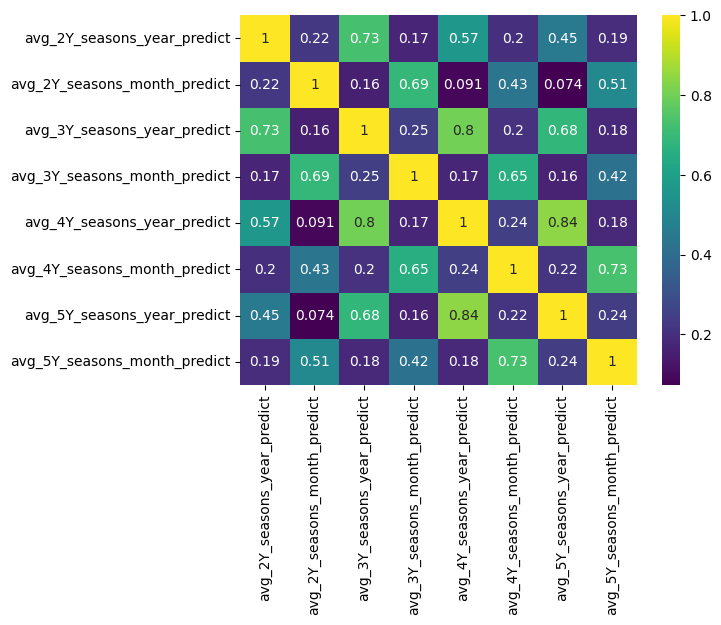

In [11]:
corr = eur_seas.dropna().iloc[:, 10:].corr()

sns.heatmap(corr, annot=True,cmap='viridis')


В итоговом датасете оставлю значения для 2 и 5 лет (наименьшая корреляция), рассчитанные для месячной и годовой точек отсчёта.

In [12]:
del eur_seas
df = calculate_seasonal_averages(eur)
df.head()

,symbol,open,high,low,close,tick_volume,year,seasons_month,seasons_year,returns,avg_2Y_seasons_year_predict,avg_2Y_seasons_month_predict,avg_5Y_seasons_year_predict,avg_5Y_seasons_month_predict
time,,,,,,,,,,,,,,
2013-01-02,EURUSD,1.32660,1.32930,1.31560,1.31860,87728,2013,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN
2013-01-03,EURUSD,1.31860,1.31900,1.30470,1.30490,101869,2013,-0.60305,-0.60305,-0.01039,NaN,NaN,NaN,NaN
2013-01-04,EURUSD,1.30480,1.30890,1.29970,1.30650,103903,2013,-1.64330,-1.64330,0.00123,NaN,NaN,NaN,NaN
2013-01-07,EURUSD,1.30750,1.31190,1.30170,1.31160,101842,2013,-1.43977,-1.43977,0.00390,NaN,NaN,NaN,NaN
2013-01-08,EURUSD,1.31160,1.31400,1.30560,1.30810,103145,2013,-1.13071,-1.13071,-0.00267,NaN,NaN,NaN,NaN



Графики сезонных колебаний цен


In [13]:

# Фильтрация данных для 2023 года
filtered_data = df[df['year'] == 2023]

fig = go.Figure()

# Определение параметров для каждой линии
lines = [
    {'column': 'avg_2Y_seasons_year_predict', 'name': 'avg_2Y_seasons_year', 'color': 'FireBrick'},
    {'column': 'avg_2Y_seasons_month_predict', 'name': 'avg_2Y_seasons_month', 'color': 'DarkOliveGreen'},
    {'column': 'avg_5Y_seasons_year_predict', 'name': 'avg_5Y_seasons_year', 'color': 'Crimson'},
    {'column': 'avg_5Y_seasons_month_predict', 'name': 'avg_5Y_seasons_month', 'color': 'OliveDrab'}
]


for line in lines:
    fig.add_trace(go.Scatter(
        x=filtered_data.index,
        y=filtered_data[line['column']],
        mode='lines+markers',
        marker=dict(size=3),
        name=line['name'],
        line=dict(width=2, color=line['color'])
    ))

# Настройка размеров графика и легенды
fig.update_layout(autosize=False, width=1500, height=700,
    legend=dict(
        orientation="h",  
        yanchor="bottom",
        y=1.02,  # Расположение над графиком
        xanchor="center",
        x=0.5
    ),
    annotations=[
        dict(
            xref='paper',
            yref='paper',
            x=0.5,
            y=1.15,
            xanchor='center',
            yanchor='top',
            text='Коррелирующие линии выделены схожим цветом',
            showarrow=False,
            font=dict(size=14)
        )]
)

fig.show()


# Features engineering          
Так как цен OHLC недостаточно для оптимальной работы прогнозной модели, то добавлю в датафрейм несколько технических индикаторов для анализа финансовых временных рядов:

#### Краткое описание применения индикаторов:

**Полосы Боллинджера (Bollinger Bands, BB):**

-   **BB\_upper\_predict:** Используется для определения потенциальных зон сопротивления цены, так как прорыв верхней полосы может указывать на перекупленность.
-   **BB\_middle\_predict:** Служит динамической скользящей средней, помогая отслеживать тренд и потенциальные точки разворота.
-   **BB\_lower\_predict:** Используется для определения потенциальных зон поддержки цены, так как прорыв нижней полосы может указывать на перепроданность.

**RSI:** Оценивает силу и скорость движения цены, помогая определить перекупленность (выше 70) и перепроданность (ниже 30) рынка.

**ADX:** Измеряет силу тренда, помогая определить его наличие и направление. Значения выше 25 обычно указывают на сильный тренд.

**Экспоненциальная скользящая средняя (EMA):** Используется для сглаживания ценовых колебаний и определения долгосрочного тренда. EMA с длительным периодом 550 дней будет являться уровнем поддержки/сопротивления и указывать на более глобальный долгосрочный тренд.

**Accumulation/Distribution Index (A/D):** Индекс накопления/распределения отражает соотношение между покупками и продажами, помогая определить накопление или распределение актива. В данном случае использованы тиковые объёмы актива, так как данные о реальных объёмах торгов отсутствуют в платформе metatrader. Дивиргенция цены и индикатора может говорить о начале разворота тренда.

In [14]:
df['BB_upper_predict']= ta.volatility.BollingerBands(df['close'], window=10, window_dev=1).bollinger_hband().shift(1)
df['BB_middle_predict'] = ta.volatility.BollingerBands(df['close'], window=10, window_dev=1).bollinger_mavg().shift(1)
df['BB_lower_predict'] = ta.volatility.BollingerBands(df['close'], window=10, window_dev=1).bollinger_lband().shift(1)
df['RSI_predict'] = ta.momentum.RSIIndicator(df['close'], window=10).rsi().shift(1)
df['ADX_predict'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close'], window=3).adx().shift(1)
df['EMA_predict'] = ta.trend.EMAIndicator(df['close'], window=550).ema_indicator().shift(1)
df['A/D_predict'] = ta.volume.AccDistIndexIndicator(df['high'], df['low'], df['close'], df['tick_volume']).acc_dist_index().shift(1)


##### Также для индикатора A/D дополнительно добавлю уровни перекупленности/перепроданности **A/D\_upper\_predict, A/D\_lower\_predict:** в размере 2 СКО.

In [15]:
# Вычисление уровней
def calculate_levels(series, window=14):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_level = rolling_mean + (2 * rolling_std)
    lower_level = rolling_mean - (2 * rolling_std)
    return upper_level, lower_level

# Добавление уровней в DataFrame
df['A/D_upper_predict'], df['A/D_lower_predict'] = calculate_levels(df['A/D_predict'])

##### Визуализация уровней:

In [16]:
# Отображение последних 100 дней
df_last_100 = df.tail(100)

fig = go.Figure()

# Добавление линии A/D
fig.add_trace(go.Scatter(x=df_last_100.index, y=df_last_100['A/D_predict'], mode='lines', name='A/D'))

# Добавление верхнего и нижнего уровней
fig.add_trace(go.Scatter(x=df_last_100.index, y=df_last_100['A/D_upper_predict'], mode='lines', name='A/D upper', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=df_last_100.index, y=df_last_100['A/D_lower_predict'], mode='lines', name='A/D Lower', line=dict(dash='dash')))

# Настройка осей и заголовка
fig.update_layout(
    title='Accumulation/Distribution Indicator with Upper and Lower Levels',
    xaxis_title='Date',
    yaxis_title='A/D Value',
    xaxis=dict(type='date')
)

fig.show()


#### Добавление лаговых признаков

In [17]:
# Добавление лаговых признаков

variables = ['open', 'high', 'low', 'close', 'BB_upper_predict', 'BB_middle_predict', 'BB_lower_predict', 'RSI_predict', 
             'ADX_predict', 'EMA_predict', 'A/D_predict', 'A/D_upper_predict', 'A/D_lower_predict', 
             'returns']

for var in variables:
    for i in range(1, 6):
        if var in ('returns', 'open', 'high', 'low', 'close'):
            df[f'{var}_lag-{i}_predict'] = df[var].shift(i)
        else:
            df[f'{var}_lag-{i}'] = df[var].shift(i)

df.head()

,symbol,open,high,low,close,tick_volume,year,seasons_month,seasons_year,returns,avg_2Y_seasons_year_predict,avg_2Y_seasons_month_predict,avg_5Y_seasons_year_predict,avg_5Y_seasons_month_predict,BB_upper_predict,BB_middle_predict,BB_lower_predict,RSI_predict,ADX_predict,EMA_predict,A/D_predict,A/D_upper_predict,A/D_lower_predict,open_lag-1_predict,open_lag-2_predict,open_lag-3_predict,open_lag-4_predict,open_lag-5_predict,high_lag-1_predict,high_lag-2_predict,high_lag-3_predict,high_lag-4_predict,high_lag-5_predict,low_lag-1_predict,low_lag-2_predict,low_lag-3_predict,low_lag-4_predict,low_lag-5_predict,close_lag-1_predict,close_lag-2_predict,close_lag-3_predict,close_lag-4_predict,close_lag-5_predict,BB_upper_predict_lag-1,BB_upper_predict_lag-2,BB_upper_predict_lag-3,BB_upper_predict_lag-4,BB_upper_predict_lag-5,BB_middle_predict_lag-1,BB_middle_predict_lag-2,BB_middle_predict_lag-3,BB_middle_predict_lag-4,BB_middle_predict_lag-5,BB_lower_predict_lag-1,BB_lower_predict_lag-2,BB_lower_predict_lag-3,BB_lower_predict_lag-4,BB_lower_predict_lag-5,RSI_predict_lag-1,RSI_predict_lag-2,RSI_predict_lag-3,RSI_predict_lag-4,RSI_predict_lag-5,ADX_predict_lag-1,ADX_predict_lag-2,ADX_predict_lag-3,ADX_predict_lag-4,ADX_predict_lag-5,EMA_predict_lag-1,EMA_predict_lag-2,EMA_predict_lag-3,EMA_predict_lag-4,EMA_predict_lag-5,A/D_predict_lag-1,A/D_predict_lag-2,A/D_predict_lag-3,A/D_predict_lag-4,A/D_predict_lag-5,A/D_upper_predict_lag-1,A/D_upper_predict_lag-2,A/D_upper_predict_lag-3,A/D_upper_predict_lag-4,A/D_upper_predict_lag-5,A/D_lower_predict_lag-1,A/D_lower_predict_lag-2,A/D_lower_predict_lag-3,A/D_lower_predict_lag-4,A/D_lower_predict_lag-5,returns_lag-1_predict,returns_lag-2_predict,returns_lag-3_predict,returns_lag-4_predict,returns_lag-5_predict
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,EURUSD,1.32660,1.32930,1.31560,1.31860,87728,2013,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,EURUSD,1.31860,1.31900,1.30470,1.30490,101869,2013,-0.60305,-0.60305,-0.01039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,-49306.97810,NaN,NaN,1.32660,NaN,NaN,NaN,NaN,1.32930,NaN,NaN,NaN,NaN,1.31560,NaN,NaN,NaN,NaN,1.31860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,EURUSD,1.30480,1.30890,1.29970,1.30650,103903,2013,-1.64330,-1.64330,0.00123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,-148326.49558,NaN,NaN,1.31860,1.32660,NaN,NaN,NaN,1.31900,1.32930,NaN,NaN,NaN,1.30470,1.31560,NaN,NaN,NaN,1.30490,1.31860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-49306.97810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.01039,NaN,NaN,NaN,NaN
2013-01-07,EURUSD,1.30750,1.31190,1.30170,1.31160,101842,2013,-1.43977,-1.43977,0.00390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,-98633.75645,NaN,NaN,1.30480,1.31860,1.32660,NaN,NaN,1.30890,1.31900,1.32930,NaN,NaN,1.29970,1.30470,1.31560,NaN,NaN,1.30650,1.30490,1.31860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-148326.49558,-49306.97810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00123,-0.01039,NaN,NaN,NaN
2013-01-08,EURUSD,1.31160,1.31400,1.30560,1.30810,103145,2013,-1.13071,-1.13071,-0.00267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,-2782.46234,NaN,NaN,1.30750,1.30480,1.31860,1.32660,NaN,1.31190,1.30890,1.31900,1.32930,NaN,1.30170,1.29970,1.30470,1.31560,NaN,1.31160

#### Подготовка данных для модели

In [18]:
# Удаление пропущенных значений
df = df.dropna()

# Фильтрация признаков
df_X = df.filter(like='_predict')
df_y = df[["returns"]]

# Разделение данных на обучающую, тестовую и валидационную выборки
split_train_test = int(0.70 * len(df))  # 70% данных для обучения
split_test_valid = int(0.90 * len(df))  # 20% данных для тестирования и 10% для валидации

# Обучающая выборка
X_train = df_X.iloc[:split_train_test]
y_train_reg = df_y.iloc[:split_train_test]
y_train_cla = np.round(y_train_reg + 0.5) #рост/падение

# Тестовая выборка
X_test = df_X.iloc[split_train_test:split_test_valid]

# Валидационная выборка
X_val = df_X.iloc[split_test_valid:]

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Обучение и стандартизация обучающих признаков
X_test_scaled = scaler.transform(X_test)  # Стандартизация тестовых признаков
X_val_scaled = scaler.transform(X_val)  # Стандартизация валидационных признаков


# Подбор количества главных компонент 

In [19]:
explained_variance = []

for n in range(1,63):
    pca = PCA(n_components=n)
    pca.fit(X_train_scaled)
    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

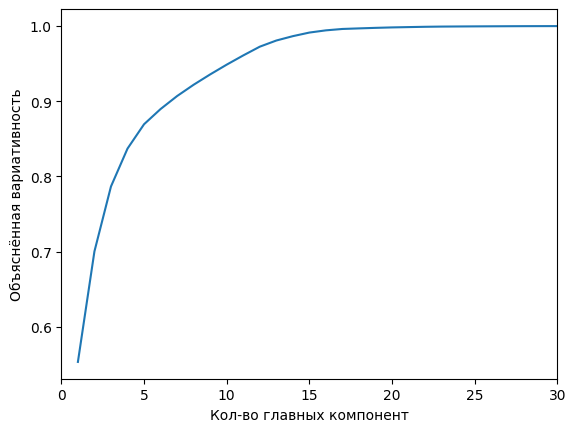

In [20]:
plt.plot(range(1,63),explained_variance)
plt.xlim(0, 30)
plt.xlabel("Кол-во главных компонент")
plt.ylabel("Объяснённая вариативность");

В районе 15 компонент выход на плато.           
Обучаю модель на 15 компонентах

In [21]:
pca = PCA(n_components=15) #Инициализация PCA с 15 компонентами
principal_components = pca.fit_transform(X_train_scaled)

In [22]:
np.sum(pca.explained_variance_ratio_)

0.9911640612596865

Сокращение размерности пространства признаков с 63 до 15 сохранит ~99% дисперсии данных и ускорит работу модели.

In [23]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)


## Decision tree classifier

In [24]:
#обучение
dtc = DecisionTreeClassifier(max_depth=6)
dtc.fit(X_train_pca, y_train_cla)


DecisionTreeClassifier(max_depth=6)

In [25]:

# прогноз
df["prediction"] = dtc.predict(np.concatenate((X_train_pca, X_test_pca, X_val_pca),axis=0))
df["prediction"] = np.where(df["prediction"]==0, -1, 1)

df["returns_predict"] = df["prediction"] * df["returns"]
returns_predict = df["returns_predict"].iloc[split_train_test:split_test_valid]
portfolio = pd.DataFrame(returns_predict)


Рассчитаю коэффициент Шарпа. Так как данные дневные, то домножу на корень из среднего количества торговых дней в году

In [26]:
# Уменьшаю доходность на среднюю величину спреда в процентах

def sharpe_ratio(returns, spread=0.00011):
    return np.sqrt(260) * (returns.mean()-(spread))/ returns.std()

sharpe= sharpe_ratio(returns_predict)
round(sharpe, 3)


0.041

Вычислю просадку

In [27]:
def drawdown(portfolio):
    # Подсчет накопленной доходности
    cum_rets = (portfolio+1).cumprod()

    # Вычисление скользящего максимума
    running_max = np.maximum.accumulate(cum_rets.dropna())

    # Просадка
    return ((cum_rets/running_max) - 1)


drawdown_portfolio = drawdown(portfolio)
max_drawdon =  round((-drawdown_portfolio.min())[0]*100)
print(f'максимальная просадка: {max_drawdon}%')

максимальная просадка: 9%


#### Функция для отрисовки графика просадки

In [28]:
def plot_drawdown(drawdown_portfolio):
    """
    Функция для построения графика просадки.
    
    Параметры:
    drawdown_portfolio (pd.DataFrame): Временной ряд просадки. 
    
    Возвращает:
    None
    """

    fig = go.Figure()

    # Заполнение области между графиком и осью x
    fig.add_trace(go.Scatter(
        x=drawdown_portfolio.index, 
        y=drawdown_portfolio.iloc[:, 0] * 100, 
        mode='lines',
        fill='tozeroy',
        fillcolor= 'rgba(143, 188, 143, 0.5)'  # Цвет 'DarkSeaGreen' с прозрачностью
    ))

    # Линия графика
    fig.add_trace(go.Scatter(
        x=drawdown_portfolio.index, 
        y=drawdown_portfolio.iloc[:, 0] * 100, 
        line=dict(color='SeaGreen'),
        name='Drawdown'
    ))

    # Настройки графика
    fig.update_layout(
        title='Просадка',
        title_font_size=15,
        yaxis_title='Просадка %',
        yaxis_title_font_size=15,
        showlegend=False,
        width=1200,
        height=600
    )
    fig.show()



In [29]:
plot_drawdown(drawdown_portfolio)

#### Бенчмарк  
В качестве бенчмарка импортирую данные по ценам закрытия индекса РТС с биржи moex.

In [30]:
# Импорт индекса РТС
rts = pdr.get_data_moex('RTSI', '2010-01-01')['CLOSE'].pct_change(1).dropna()
rts.name = 'rts'

# Соединяю доходность актива и бенчмарка в один df
join = pd.concat((portfolio, rts), axis=1).dropna()

In [31]:
def plot_returns(join):
    """
    Функция для построения графика доходности на основе объединённого df с бенчмарком 'join'.
    
    Параметры:
    join: df с данными, где строки представляют даты,
                         а столбцы - доходность стратегии и доходность индекса РТС.

    Возвращает:
    None
    """
    fig = go.Figure()

    # Первая линия графика
    fig.add_trace(go.Scatter(
        x=join.index, 
        y=join.iloc[:, 0].cumsum() * 100, 
        line=dict(color='DarkSlateBlue', width=2.5), 
        name='Стратегия'
    ))

    # Вторая линия графика
    fig.add_trace(go.Scatter(
        x=join.index, 
        y=join.iloc[:, 1].cumsum() * 100, 
        line=dict(color='Maroon', width=2.5), 
        name='РТС'
    ))

    # Настройки графика
    fig.update_layout(
        title='ДОХОДНОСТЬ',
        title_font_size=15,
        yaxis_title='Доходность %',
        yaxis_title_font_size=15,
        showlegend=True,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        ),
        width=1200,  
        height=600
    )

    fig.show()



In [32]:
plot_returns(join)

## Random Forest Regressor

In [35]:
rfr = RandomForestRegressor()

# Параметры для GridSearchCV
param = {"max_depth": [3, 6, 15], "n_estimators": [10, 50, 100, 150]}

# Критерий Шарпа
def sharpe(y, y_pred):
    r = np.sign(y_pred) * y
    return np.mean(r) / np.std(r)

# Преобразование критерия в метрику
sharpe_metric = make_scorer(sharpe, greater_is_better=True)

# Создание модели GridSearchCV с использованием критерия Шарпа для оценки
rfr_grig = GridSearchCV(rfr, param_grid=param, scoring=sharpe_metric, cv=3)

# Обучение модели на тренировочных данных
rfr_grig.fit(X_train_pca, y_train_reg)

# Получение лучшей модели
rfr_grig.best_estimator_


RandomForestRegressor(max_depth=3, n_estimators=10)

Применение модели

In [40]:
df["prediction"] = rfr_grig.predict(np.concatenate((X_train_pca, X_test_pca, X_val_pca),axis=0))

df["returns_predict"] = np.sign(df["prediction"]) * df["returns"]
returns_predict = df["returns_predict"].iloc[split_train_test:split_test_valid]

In [41]:
estimation.get_estimate(returns_predict)


    -----------------------------------------------------------------------------
    Максимальная просадка: 10% 	
    Коэффициент Шарпа: -0.213 	 
    -----------------------------------------------------------------------------
    


Бэктест показывает не очень хорошие результаты работы моделей. Отрицательный коэффициент Шарпа говорит о рисках потери денег при выборе данной стратегии. Также здесь применён бэктест портфеля без учёта кредитного плеча, стоп-лосса и тейк-профита. 

Далее, в файле 'Итоговый проект', будет применен алгоритм подбора нескольких инструментов с бектестом для создания инвестиционного портфеля, оптимизация весовых коэффициентов с помощью функции средней ассиметрии-эксцесса для снижения инвестиционных рисков, а также оптимизация и применение кредитного плеча, стоп-лосса и тейк-профита.